<a href="https://colab.research.google.com/github/pilgyeong/SR-keywordAnalysis/blob/main/EA_SRdata_keywordAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. 환경설정**

#### **0-1. Drive Mount**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####**0-2. Colab에서 konlpy 및 mecab 설치하기**
- https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
- Bash shell 명령어 활용

In [2]:
# install konlpy mecab package
!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

+ pip install konlpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 453 kB 50.5 MB/s 
+ curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
+ bash -x
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ echo 'Installing automake (A dependency for mecab-ko)'
Installing automake (A dependency for mecab-ko)
+ install_automake
+ '[' Linux == Linux ']'
++ grep -Ei 'debian|buntu|mint' /etc/lsb-release /etc/os-release
+ '[' '/etc/lsb-release:DISTRIB_ID=Ubuntu
/etc/lsb-release:DISTRIB_DESCRIPTION="Ubuntu 18.04.6 LTS"
/etc/os-release:NAME="Ubuntu"
/etc/os-release:ID=ubuntu
/etc/os-release:ID_LIKE=debian
/e

#### **0-2. 워드클라우드 및 폰트 설치**
- Install wordcloud
- Install squarify

In [4]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **1. 분석작업세팅**

#### **1-1. Import packages**

In [33]:
# 파이썬 일반
import os
import re
import sys
import json
import tqdm
import random
import pickle
import string
import webbrowser
import warnings
warnings.filterwarnings('ignore')

# 파이썬 데이터 분석/시각화 등
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from matplotlib import rc
from matplotlib import font_manager
from collections import Counter
from wordcloud import WordCloud

from PIL import Image

# 파이썬 텍스트/자연어 처리
import nltk
import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from konlpy.tag import Mecab
from sklearn.metrics.pairwise import linear_kernel
from pykospacing import Spacing
from tqdm import tqdm
from math import log
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# 파이썬 기본 Setting
fontpath = '/content/drive/MyDrive/Colab Notebooks/NanumGothic.ttf' #폰트경로

# fit
mecab = Mecab()

#### **1-2. To define a function**
- make_wordlist : 의미있는 단어를 추출하여 리스트화 해주는 함수
- preprocess : 주어진 문장에서 의미있는 단어를 추출하는 함수
- extract_word : 한국어만 추출하는 함수
- tf_idf : TF-IDF 벡터화 함수

In [8]:
# 의미있는 단어 리스트 추출해주는 함수
def make_wordlist(text, stopwords): #text = " ".join(data['Review'].tolist())
    print("Rawdata를 문장 정리 중...")
    #정규표현식 적용
    print("데이터 정제 중...")
    words = extract_word(text)
    #형태소 추출
    print("형태소 추출 중...")
    words = mecab.morphs(words)
    #한글자 제거
    print("한글자 제거 중...")
    words = [x for x in words if len(x)>1 or x =='닉']
    #불용어 제거
    print("불용어 제거 중...")
    words = [x for x in words if x not in stopwords]
    #최소횟수 미만 제거
    print("의미있는 단어리스트 생성 중...")
    # time.sleep(1)
    minimum_count = 3
    final = []
    for i in tqdm(range(len(words))):
      tmp = words[i]
      if words.count(tmp) >= minimum_count:
          final.append(tmp)
    return set(final) #조건을 만족하는 단어 리스트

# 문장 중 의미있는 단어를 전처리
def preprocess(text, word_list):
  text = extract_word(text)
  mecab = Mecab()
  text = mecab.morphs(text)
  text = [x for x in text if x in word_list]
  return text

# 불용어리스트 만들기
def load_stopwords(basepath):
  print("불용어셋을 가져오고 있습니다.")
  with open(basepath, 'r', encoding = 'utf-8-sig') as f:
    list_file = f.read().splitlines()
  return list_file[0].split()

# 한글 단어 외 모두 제거
def extract_word(text):
  hangul = re.compile('[^가-힣]') 
  result = hangul.sub(' ', text) 
  return result

# TF-IDF Vectorizer 함수
def tf_idf(self):
  vectorizer = CountVectorizer(tokenizer = lambda x: preprocess(x, word_list))
  data_features = vectorizer.fit_transform(self.tolist())
  tfidf_vectorizer = TfidfTransformer()
  tf_idf_vect = tfidf_vectorizer.fit_transform(data_features)
  global invert_index_vectorizer
  invert_index_vectorizer = {v: k for k, v in vectorizer.vocabulary_.items()}
  return tf_idf_vect

# CountVectorizer 함수
def count_vectorizer(self):
  vectorizer = CountVectorizer(tokenizer = lambda x: preprocess(x, word_list))
  data_features = vectorizer.fit_transform(self.tolist())

  # CountVectorizer Word(단어) List
  list_of_word = vectorizer.get_feature_names()

  # CountVectorizer Word Count(단어 빈도) List
  count_list = data_features.toarray().sum(axis=0)

  # list_of_word 및 count_list를 index 기준으로 묶음
  word_count_dict = dict(zip(word_list, count_list))
  return word_count_dict

# 예측모델 성능지표 추출
def model_performance(self):
  # 예측모델 성능지표 값
  print('accuracy: %.2f' % accuracy_score(y, y_pred))
  print('precision: %.2f' % precision_score(y, y_pred))
  print('recall: %.2f' % recall_score(y, y_pred))
  print('F1: %.2f' % f1_score(y, y_pred))

  # confusion matrix 시각화
  confu = confusion_matrix(y_true = y, y_pred = y_pred)
  plt.figure(figsize=(4, 3))
  sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
  plt.title('Confusion Matrix')
  plt.show()

# 단어 개수 카운팅 함수
def word_count(keyword):
  cnt = 0
  for word in df_content['text']:
    temp_wordlist = preprocess(word, word_list)
    if keyword in temp_wordlist:
      cnt = cnt + 1
  return cnt

#### **1-3. Loading Rawdata & Stopwords**
- Rawdata(dataframe) Load
- StopWords(list) Create

In [9]:
# 분석용 Raw Data Load
path = '/content/drive/MyDrive/Colab Notebooks/srdata_keywordAnalysis/srdata_v2.csv'
df = pd.read_csv(path)

# # 불용어(StopWords) 리스트 생성
stopword_path = '/content/drive/MyDrive/Colab Notebooks/srdata_keywordAnalysis/kor_stopwords.txt'
stopwords = load_stopwords(stopword_path)

불용어셋을 가져오고 있습니다.


#### **1-4. To preprocess rawdata first**
- first preprocess > content, action 분리하여 셋 구축

In [10]:
# content와 action 컬럼 분리하여 데이터 셋 구축
df_content = df.drop(['id', 'process', 'title', 'action'], axis=1)
df_content.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)
df_content.rename(columns={'content':'text'}, inplace=True)
df_content.reset_index(drop=True, inplace=True)

df_action = df.drop(['id', 'process', 'title', 'content'], axis=1)
df_action.rename(columns={'action':'text'}, inplace=True)
df_action.reset_index(drop=True, inplace=True)

# df_content

#### **1-5. EDA**
- 탐색적분석(Exploratory Data Analysis)

In [11]:
# info 컬럼 정보 확인
print("df_content.info() is: \n")
print(df_content.info())
print("\n")
print("df_action.info() is: \n")
print(df_action.info())

df_content.info() is: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2596 entries, 0 to 2595
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   system  2596 non-null   int64 
 1   text    2596 non-null   object
dtypes: int64(1), object(1)
memory usage: 40.7+ KB
None


df_action.info() is: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7968 entries, 0 to 7967
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   system  7968 non-null   int64 
 1   text    7964 non-null   object
dtypes: int64(1), object(1)
memory usage: 124.6+ KB
None


In [12]:
# describe 통계값 확인
print("df_content.describe() is: \n")
print(df_content.describe(include='all'))
print("\n")
print("df_action.describe() is: \n")
print(df_action.describe(include='all'))

df_content.describe() is: 

             system                                               text
count   2596.000000                                               2596
unique          NaN                                               2593
top             NaN  기관명: 통계청\n\n사업명: 인공지능 기반 통계분류 자동화 시스템 구축\n\n\n...
freq            NaN                                                  2
mean       0.887134                                                NaN
std        0.316490                                                NaN
min        0.000000                                                NaN
25%        1.000000                                                NaN
50%        1.000000                                                NaN
75%        1.000000                                                NaN
max        1.000000                                                NaN


df_action.describe() is: 

             system                                               text
count   7968.000000 

In [13]:
# system = 1,0 개수 확인
print("df_content['system'].value_counts() is: \n")
print(df_content['system'].value_counts())
print("\n")
print("df_action['system'].value_counts() is: \n")
print(df_action['system'].value_counts())

df_content['system'].value_counts() is: 

1    2303
0     293
Name: system, dtype: int64


df_action['system'].value_counts() is: 

1    7373
0     595
Name: system, dtype: int64


# **2. 데이터 전처리**

#### **2-1. Data Preprocessing**
- Meaningful Word List : make_wordlist 함수
- Data Frame Word Preprocessing : preprocess 함수

In [14]:
# Meaningful Word List 추출 -> word_list
word_list = make_wordlist(" ".join(df_content['text'].tolist()), stopwords)

Rawdata를 문장 정리 중...
데이터 정제 중...
형태소 추출 중...
한글자 제거 중...
불용어 제거 중...
의미있는 단어리스트 생성 중...


100%|██████████| 96878/96878 [06:24<00:00, 252.21it/s]


# **3. 벡터화 및 토큰화**

#### **3-1. Count Vectorizer**
- count_vectorizer 함수
- CountVectorizer : 단어의 출현 빈도로 여러 문장(또는 문서) 벡터화

In [15]:
count_vect = count_vectorizer(df_content['text'])
count_vect

{'차원': 11,
 '산정': 7,
 '수신': 192,
 '미회': 6,
 '소리': 10,
 '비산': 8,
 '스마트': 27,
 '방사능': 6,
 '스케어': 4,
 '예비': 4,
 '빠른': 3,
 '조광진': 6,
 '게시': 3,
 '광역자치단체': 5,
 '플러그인': 5,
 '고시': 4,
 '준공': 11,
 '동물': 1107,
 '방역': 5,
 '의견서': 6,
 '영구': 3,
 '용어': 11,
 '새로': 5,
 '구글': 4,
 '계획서': 3,
 '이동식': 3,
 '화학': 8,
 '시내버스': 26,
 '도구': 4,
 '위원': 17,
 '화상': 790,
 '노동부': 75,
 '마련': 49,
 '회원': 21,
 '였으니': 317,
 '충청남도': 5,
 '정부': 10,
 '예시': 5,
 '만점': 15,
 '보수': 19,
 '국희': 12,
 '건지': 71,
 '금요일': 10,
 '통화': 25,
 '지연': 16,
 '누르': 36,
 '을까': 29,
 '인계인수': 7,
 '주체': 3,
 '입찰': 13,
 '방촌': 39,
 '등재': 42,
 '전라남도': 4,
 '대통령': 10,
 '대책': 3,
 '영암군': 7,
 '이루어지': 4,
 '복합': 23,
 '희망': 4,
 '퇴직': 40,
 '수도': 4,
 '접근': 4,
 '내역': 8,
 '작성': 5,
 '달발': 1207,
 '교육부': 11,
 '별첨': 16,
 '이승호': 8,
 '달리': 3,
 '교통안전': 7,
 '그냥': 1253,
 '흥원': 6,
 '산재': 10,
 '드림': 10,
 '책정': 6,
 '전용주': 3,
 '첨단': 6,
 '무관': 5,
 '효과': 3,
 '어서요': 31,
 '이월': 48,
 '충북': 6,
 '관광공사': 5,
 '경쟁': 6,
 '가족': 3,
 '과거': 5,
 '신고': 9,
 '결과': 7,
 '영동군': 4,
 '보건': 10,
 '어항': 25,
 '검역

#### **3-2. TF-IDF Vectorizer**
- tf_idf 함수
- TF-IDF(Term Frequency-Inverse Document Frequency)는 단어의 빈도와 역 문서 빈도(문서의 빈도에 특정 식을 취함)를 사용하여 DTM 내의 각 단어들마다 중요한 정도를 가중치로 주는 방법

In [17]:
# TF-IDF Vectorizer 및 {인덱스:단어} 맵핑
tf_idf_vect = tf_idf(df_content['text'])

# tf_idf_vect
invert_index_vectorizer

{958: '세요',
 984: '수고',
 1314: '으십니다',
 1127: '어플리케이션',
 1057: '신규',
 30: '개발',
 43: '거나',
 1492: '전면',
 177: '관련',
 257: '규정',
 1815: '클라우드',
 1807: '컴퓨팅',
 1369: '이용',
 64: '검토',
 1148: '여야',
 1944: '한다',
 538: '라고',
 1120: '어서',
 841: '사업',
 102: '계획서',
 854: '사전',
 1999: '협의',
 1446: '자체',
 70: '결과',
 491: '도입',
 623: '문서',
 1730: '첨부',
 546: '려고',
 1957: '합니다',
 858: '사항',
 306: '기준',
 1747: '체크',
 665: '박스',
 1320: '을지',
 522: '드립니다',
 1542: '정정',
 1568: '제출',
 1722: '처리',
 1239: '완료',
 1248: '요청',
 1700: '차세대',
 1845: '통합',
 178: '관리',
 1040: '시스템',
 225: '구축',
 1286: '위한',
 295: '기본',
 940: '설계',
 1252: '용역',
 1288: '위해',
 1131: '업로드',
 1867: '파일',
 1453: '잘못',
 811: '붙임',
 792: '부탁',
 2000: '협조',
 981: '송부',
 1415: '일자',
 1005: '수정',
 17: '감사',
 1559: '제안',
 1249: '요청서',
 2018: '화성',
 489: '도시',
 142: '공사',
 90: '경영',
 1530: '정보',
 1426: '입니다',
 1089: '아래',
 465: '대한',
 1331: '의견',
 671: '반영',
 1969: '해야',
 1946: '한다는',
 1732: '청건',
 1132: '업명',
 2019: '화성시',
 1744: '체육',
 103

# **4. TF-IDF 행렬 및 Cosine 유사도 측정**
- TF-IDF Matrix 생성
- Cosine Similarity 측정

#### **4-1. TF-IDF Matrix**

In [19]:
# TF-IDF Matrix 생성
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df_content['text'])
tfidf_matrix

<2596x18797 sparse matrix of type '<class 'numpy.float64'>'
	with 75138 stored elements in Compressed Sparse Row format>

#### **4-2. Cosine Similarity**

In [20]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.00418293, 0.        , ..., 0.00198298, 0.00267294,
        0.00503085],
       [0.00418293, 1.        , 0.08318298, ..., 0.00287886, 0.00388053,
        0.01306147],
       [0.        , 0.08318298, 1.        , ..., 0.01145288, 0.        ,
        0.00290153],
       ...,
       [0.00198298, 0.00287886, 0.01145288, ..., 1.        , 0.58605999,
        0.00663513],
       [0.00267294, 0.00388053, 0.        , ..., 0.58605999, 1.        ,
        0.01186206],
       [0.00503085, 0.01306147, 0.00290153, ..., 0.00663513, 0.01186206,
        1.        ]])

# **5. Logistic Regression Model**

#### **5-1. Second preprocessing before model learning**
- 편향된 학습을 방지하기 위해 1/0 (P/N) 비율을 적절히 맞춰줘야함
- 순차적인 학습으로 편향된 결과 방지를 위해 1/0 인덱스를 랜덤 셔플
- 학습용 데이터(X, Y) 세팅

In [21]:
# system = 1,0 중 최소값 추출
min_cnt = min(df_content['system'].value_counts().tolist())
pos_random_idx = df_content[df_content['system']==1].sample(min_cnt, random_state=40).index.tolist()
neg_random_idx = df_content[df_content['system']==0].sample(min_cnt, random_state=40).index.tolist()

In [22]:
# 데이터 값 셔플: 데이터 값이 순차적일 경우, 먼저 나온 라벨 기준 학습으로 편향될 가능성 존재
import random
random_idx = pos_random_idx + neg_random_idx
random.shuffle(random_idx)

In [23]:
# x : index 매핑된 TF_IDF Vector
# y : system (1/0) 라벨
x = tf_idf_vect[random_idx]
y = df_content['system'][random_idx]

#### **5-2. LogisticRegression Model fit**

In [24]:
model = LogisticRegression()
model.fit(x, y)

LogisticRegression()

#### **5-3. Check model performance**
- model_performance 함수

accuracy: 0.98
precision: 0.98
recall: 0.98
F1: 0.98


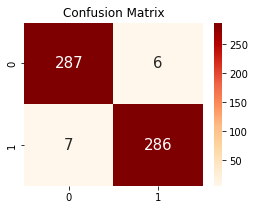

In [25]:
# 예측모델 성능지표 값
y_pred = model.predict(x)
model_performance(y_pred)

# **6. 중요 키워드 추출**
- 모델이 학습한 결과를 가지고 키워드를 추출
- 긍정(system=1)에는 어떤 키워드가 영향을 주었는지, 부정(system=0)에는 어떤 키워드가 영향을 주었는지
- 로지틱스 회귀모델의 coef_속성 지표로 추출

#### **6-1. coef 속성값의 index list생성**

In [26]:
# df_content
coef_pos_index = sorted(((value, index) for index, value in enumerate(model.coef_[0])), reverse = True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(model.coef_[0])), reverse = False)

In [27]:
# 통계 추출용
keywords_list = []

In [28]:
# 긍정(system=1)에 영향 준 상위 n개 키워드
N = 10
for coef in coef_pos_index[:N]:
  print(invert_index_vectorizer[coef[1]], coef[0])
  keywords_list.append(invert_index_vectorizer[coef[1]])

요청 2.9934717486020643
수정 2.773248143362135
변경 2.4080905232714516
삭제 1.9925047487348029
등록 1.3828242380015703
파일 1.3607354302120238
업명 1.1921592062484867
담당자 1.1808846089674039
단계 1.0486557617368988
현황 0.9304521273500402


# **7. 통계 추출**

#### 7-1. 상위 키워드 등장한 SR 건수

In [29]:
df_stats = pd.DataFrame(columns=['keyword', 'count'])
keyword_cnt_dict = {}
for word in keywords_list:
  cnt = word_count(word) 
  keyword_cnt_dict[word] = cnt
keyword_cnt_dict

# temp_cnt = 0
# cnt = 0
# for word in df_content['text']:
#   temp = preprocess(word, word_list)
#   for text in temp:
#     if text in keywords_list[0:3]:
#       cnt = cnt + 1
#       break
# # df_content.info()
# print("키워드 등장한 질문 개수: ", cnt)
# print("전체 질문 개수: ", 2596 )

{'요청': 1500,
 '수정': 780,
 '변경': 893,
 '삭제': 284,
 '등록': 816,
 '파일': 490,
 '업명': 712,
 '담당자': 490,
 '단계': 348,
 '현황': 300}

# **8. 시각화**

#### 8-1. Word Cloud

In [30]:
# 상위 N개 키워드 Dictionary에 저장
top_keyword_dict = {}
for coef in coef_pos_index[:N]:
  top_keyword_dict.setdefault(invert_index_vectorizer[coef[1]], coef[0])
top_keyword_dict

{'요청': 2.9934717486020643,
 '수정': 2.773248143362135,
 '변경': 2.4080905232714516,
 '삭제': 1.9925047487348029,
 '등록': 1.3828242380015703,
 '파일': 1.3607354302120238,
 '업명': 1.1921592062484867,
 '담당자': 1.1808846089674039,
 '단계': 1.0486557617368988,
 '현황': 0.9304521273500402}

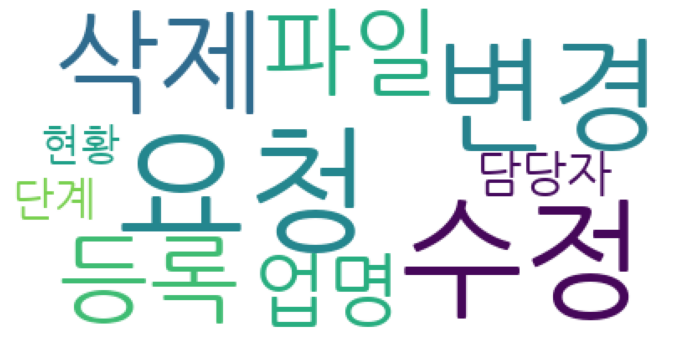

In [35]:
# WordCloud 시각화
wc = WordCloud(background_color='white', font_path='/content/drive/MyDrive/Colab Notebooks/srdata_keywordAnalysis/NanumGothic.ttf')
wc.generate_from_frequencies(top_keyword_dict)
figure = plt.figure(figsize=(12,12))
ax = figure.add_subplot(1,1,1)
ax.axis('off')
ax.imshow(wc)
plt.show();

In [ ]:
# 파일 저장
# wc.to_file('/content/drive/MyDrive/Colab Notebooks/WordCloud002.jpg')